In [1]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import display, HTML
from fastdownload import FastDownload

In [108]:
fp = FastDownload().download("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")
with open(fp) as f:
    data = f.read()
data[:100]
device = "cuda"

## Tokenizer

In [92]:
vocab = list(set(data))
c2i = lambda c: vocab.index(c)
i2c = lambda i: vocab[i]
ds = torch.tensor([c2i(d) for d in data[:len(data)]]).cuda()

def decode(x):
    return "".join([i2c(i) for i in x])

## Model

In [132]:
class Hidden(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(Hidden, self).__init__()
        self.hidden_dim = hidden_dim
        self.i2h = nn.Linear(in_dim, hidden_dim, bias=False)
        self.h2h = nn.Linear(hidden_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, hidden):
        hidden = hidden + F.relu(self.i2h(x) + self.h2h(hidden))
        out = x + F.relu(self.h2o(hidden))
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_dim).to(device)

In [235]:
class LM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1):
        super(LM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.grus = [nn.GRU(embed_dim, hidden_dim, batch_first=True)] + [nn.GRU(hidden_dim, hidden_dim, batch_first=True) for i in range(1, num_layers)]
        self.grus = nn.ModuleList(self.grus)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    
    def forward(self, x):
        emb = self.embedding(x)
        out, h = self.grus[0](emb)
        for gru in self.grus[1:]:
            out_hat, h = gru(out)
            out = out + out_hat
        out = self.linear(out)
        # out = F.log_softmax(out, dim=-1)
        return out
        
class LM2(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1):
        super(LM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # self.gru = [nn.GRU(embed_dim, hidden_dim, batch_first=True) for i in range(num_layers)]
        self.hidden = Hidden(embed_dim, hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, h=None):
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        outs = []
        if h is None:
            h = self.hidden.init_hidden(batch_size)
        for i in range(seq_len):
            out, h = self.forward_step(x[:,i], h)
            outs.append(out)
        return torch.stack(outs).permute(1,0,2)
            
    
    def forward_step(self, x, h):
        emb = self.embedding(x)
        # out, h = self.gru(emb)
        out, h = self.hidden(emb, h)
        out = self.linear(out)
        # out = F.log_softmax(out, dim=-1)
        return out, h

## Loop

In [262]:
import torch.optim as optim
embed_dim = 128
hidden_size = 512
num_layers = 8
lr = 2e-3

In [263]:
lm = LM(len(vocab), embed_dim, hidden_size, num_layers).cuda()
opt = optim.Adam(lm.parameters(), lr)

In [299]:
torch.logsumexp(y_hat, 2, keepdim=True)

tensor([[[ 5.1952],
         [ 7.4292],
         [ 8.3600],
         ...,
         [11.1640],
         [16.0264],
         [12.1417]],

        [[ 7.4082],
         [10.9656],
         [11.0267],
         ...,
         [12.3141],
         [10.6161],
         [15.0083]],

        [[ 5.1603],
         [11.4615],
         [15.3404],
         ...,
         [13.5202],
         [21.5298],
         [11.4583]],

        ...,

        [[ 5.6171],
         [ 5.5626],
         [13.2406],
         ...,
         [11.5311],
         [17.2710],
         [11.1150]],

        [[ 6.0269],
         [ 5.9179],
         [11.0488],
         ...,
         [ 7.2227],
         [16.6334],
         [11.4600]],

        [[ 5.6166],
         [ 6.8220],
         [ 9.9757],
         ...,
         [13.6470],
         [12.6430],
         [17.0063]]], device='cuda:0', grad_fn=<LogsumexpBackward0>)

In [302]:
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import display, HTML
import numpy as np

def update_info(handle, y_pred, y, losses):
    # Create the plot for the losses
    window = 50  # smoothing window size
    if len(losses) >= window:
        smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')
    else:
        smoothed_losses = losses  # not enough data for smoothing
    fig, ax = plt.subplots()
    ax.plot(smoothed_losses, label='Loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    img_html = f"<img src='data:image/png;base64,{img_base64}'/>"

    # Create the detailed info HTML
    detailed_info = f"""\
<pre>
<hr>
<div style="display: flex;">
    <div style="flex: 1; padding-right: 10px;">
        <strong>Target:</strong>
        <p>{decode(y[0])}</p>
    </div>
    <div style="flex: 1; padding-left: 10px;">
        <strong>Predicted:</strong>
        <p>{decode(y_pred[0])}</p>
    </div>
</div>
<div style="margin-top: 10px;">
    <strong>Loss Plot:</strong>
    {img_html}
</div>
</pre>
"""
    handle.update(HTML(f"<div id='progress_output'>{detailed_info}</div>"))

def update_info2(handle, y_hat, y, losses):
    # Smooth the losses
    window = 50  # smoothing window size
    if len(losses) >= window:
        smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')
    else:
        smoothed_losses = losses  # not enough data for smoothing

    # Create the plot for the smoothed losses
    fig, ax = plt.subplots()
    ax.plot(smoothed_losses, label='Smoothed Loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    img_html = f"<img src='data:image/png;base64,{img_base64}'/>"

    # Decode the target and predictions
    target_str = decode(y[0])
    y_pred = y_hat.topk(1, -1).indices
    pred_str = decode(y_pred[0])

    # Color each letter based on prediction
    colored_text = ""
    for t, p in zip(target_str, pred_str):
        color = "green" if t == p else "red"
        colored_text += f"<span style='background-color: {color}'>{t}</span>"

    # Create the detailed info HTML
    detailed_info = f"""\
<pre>
<hr>
<div style="display: flex; flex-direction: column;">
    <div style="flex: 1; padding-right: 10px;">
        <strong>Colored Target:</strong>
        <p>{colored_text}</p>
    </div>
</div>
<div style="margin-top: 10px;">
    <strong>Loss Plot:</strong>
    {img_html}
</div>
</pre>
"""
    handle.update(HTML(f"<div id='progress_output'>{detailed_info}</div>"))
    
def update_info3(handle, y_hat, y, losses):
    # Smooth the losses
    window = 50  # smoothing window size
    if len(losses) >= window:
        smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')
    else:
        smoothed_losses = losses  # not enough data for smoothing

    # Create the plot for the smoothed losses
    fig, ax = plt.subplots()
    ax.plot(smoothed_losses, label='Smoothed Loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    img_html = f"<img src='data:image/png;base64,{img_base64}'/>"

    # Decode the target and predictions
    target_str = decode(y[0])
    y_pred = y_hat.topk(1, -1).indices[0]

    # Color each letter based on prediction
    colored_text = ""
    probs = torch.exp(y_hat - torch.logsumexp(y_hat, 2, keepdim=True))
    for i, (t, p) in enumerate(zip(target_str, decode(y_pred))):
        if t != p:
            # Calculate how wrong the prediction is
            predicted_prob =probs[0, i, y_pred[i]].item()
            actual_prob = probs[0, i, y[0, i]].item()
            # print(predicted_prob, actual_prob)
            alpha = min(1, max(0, 1 - abs(predicted_prob - actual_prob)))
            color = f"rgba(255, 0, 0, {alpha})"  # red with varying alpha
            colored_text += f"<span style='background-color: {color}'>{t}</span>"
        else:
            colored_text += t

    # Create the detailed info HTML
    detailed_info = f"""\
<pre>
<hr>
<div style="display: flex; flex-direction: column;">
    <div style="flex: 1; padding-right: 10px;">
        <strong>Colored Target:</strong>
        <p>{colored_text}</p>
    </div>
</div>
<div style="margin-top: 10px;">
    <strong>Loss Plot:</strong>
    {img_html}
</div>
</pre>
"""
    handle.update(HTML(f"<div id='progress_output'>{detailed_info}</div>"))

  0%|          | 0/100000 [00:00<?, ?it/s]


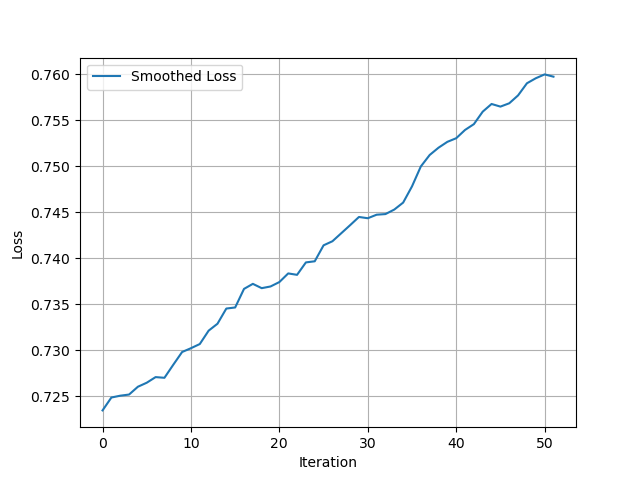

KeyboardInterrupt: 

In [303]:
bs = 64
MAX_LEN = 200
epochs = 100000
losses = []
lm.train()

progress_bar = tqdm(range(epochs)) 
display_handle = display(HTML("<div id='progress_output'></div>"), display_id=True)

for e in progress_bar:
    sample_inds = torch.randint(len(ds)-MAX_LEN-1, (bs,))
    sample = torch.stack([ds[i:i+MAX_LEN+1] for i in sample_inds]).cuda()
    x = sample[:,:-1]
    y = sample[:, 1:]
    
    lm.zero_grad()
    y_hat = lm(x)
    loss = F.cross_entropy(y_hat.reshape(-1, y_hat.size(-1)), y.flatten())
    loss.backward()
    opt.step()
    if e % 5 == 0:
        losses.append(float(loss))
        progress_bar.set_postfix(loss=f"{loss:.2f}")
    if e % 100 == 0:
        y_pred = y_hat.topk(1, -1).indices
        update_info3(display_handle, y_hat, y, losses)
    if e % 500 == 0:# and e > 0:
        torch.save(lm, f"lm_big_{e}.w")
        with open("losses.txt", 'w') as f:
            f.write(json.dumps(losses))
        

In [ ]:
y_hat.shape, y.shape

In [274]:
def generate(self, start_prompt, max_length, temperature=1.0):
    self.eval()  # Set the model to evaluation mode

    # Convert start_prompt to tensor
    input_tensor = torch.tensor(start_prompt, dtype=torch.long).unsqueeze(0).cuda()  # Add batch dimension
    
    # Initialize hidden state
    h = [None] * len(self.grus)
    
    generated_sequence = start_prompt[:]
    
    with torch.no_grad():
        for _ in range(max_length):
            # Forward pass through the model
            emb = self.embedding(input_tensor)
            out, h[0] = self.grus[0](emb, h[0])
            
            for i, gru in enumerate(self.grus[1:], 1):
                out_hat, h[i] = gru(out, h[i])
                out = out + out_hat

            out = self.linear(out)
            
            # Sample from the output distribution
            out = out[:, -1, :] / temperature
            probs = F.softmax(out, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            
            # Append the predicted token to the generated sequence
            generated_sequence.append(next_token)
            
            # Update the input tensor
            input_tensor = torch.tensor([[next_token]], dtype=torch.long).cuda()

    return generated_sequence

In [276]:
prompt = "If he did not care whether he had their love or no,"
encoded = torch.tensor([c2i(c) for c in prompt]).cuda()
encoded = [c2i(c) for c in prompt]
generated = generate(lm, encoded, 100)

In [278]:
print(decode(generated))

If he did not care whether he had their love or no, henge him:
Though inducedly lord hath cloudy nothing cursed
With lasting Richard see'st, is a noble
